<a href="https://colab.research.google.com/github/chuancao26/islp/blob/main/nonLinearExercices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ISLP

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 6.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=712bf8ea1de1387346eaf00f1b1c6f9fd590066db16563827a17476939a811a2
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [23]:
# algunos imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         poly,
                         summarize)

import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


# Applied

## 1

In [3]:
wage = load_data("Wage")
age = wage["age"]

In [4]:
wage.describe()

,year,age,logwage,wage
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,2005.791000,42.414667,4.653905,111.703608
std,2.026167,11.542406,0.351753,41.728595
min,2003.000000,18.000000,3.000000,20.085537
25%,2004.000000,33.750000,4.447158,85.383940
50%,2006.000000,42.000000,4.653213,104.921507
75%,2008.000000,51.000000,4.857332,128.680488
max,2009.000000,80.000000,5.763128,318.342430


In [5]:
wage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        3000 non-null   int64   
 1   age         3000 non-null   int64   
 2   maritl      3000 non-null   category
 3   race        3000 non-null   category
 4   education   3000 non-null   category
 5   region      3000 non-null   category
 6   jobclass    3000 non-null   category
 7   health      3000 non-null   category
 8   health_ins  3000 non-null   category
 9   logwage     3000 non-null   float64 
 10  wage        3000 non-null   float64 
dtypes: category(7), float64(2), int64(2)
memory usage: 115.5 KB


### a

vamos a hacer la regresion polinomial usando age para explicacar Wage
Necesitamos algunas cosas.
- especificar el kfold
- matriz de features
- algoritmo de regresion

#### Regresion Polinomial

In [20]:
design = MS([poly("age", degree=7)]).fit(wage)

X = design.transform(wage)
y = wage["wage"]

model = sm.OLS(y, X).fit()
summarize(model)


,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.331,0.000
"poly(age, degree=7)[0]",447.0679,39.902,11.204,0.000
"poly(age, degree=7)[1]",-478.3158,39.902,-11.987,0.000
"poly(age, degree=7)[2]",125.5217,39.902,3.146,0.002
"poly(age, degree=7)[3]",-77.9112,39.902,-1.953,0.051
"poly(age, degree=7)[4]",-35.8129,39.902,-0.898,0.370
"poly(age, degree=7)[5]",62.7077,39.902,1.572,0.116
"poly(age, degree=7)[6]",50.5498,39.902,1.267,0.205


vamos a graficar la funcion estimada

Text(0, 0.5, 'wage')

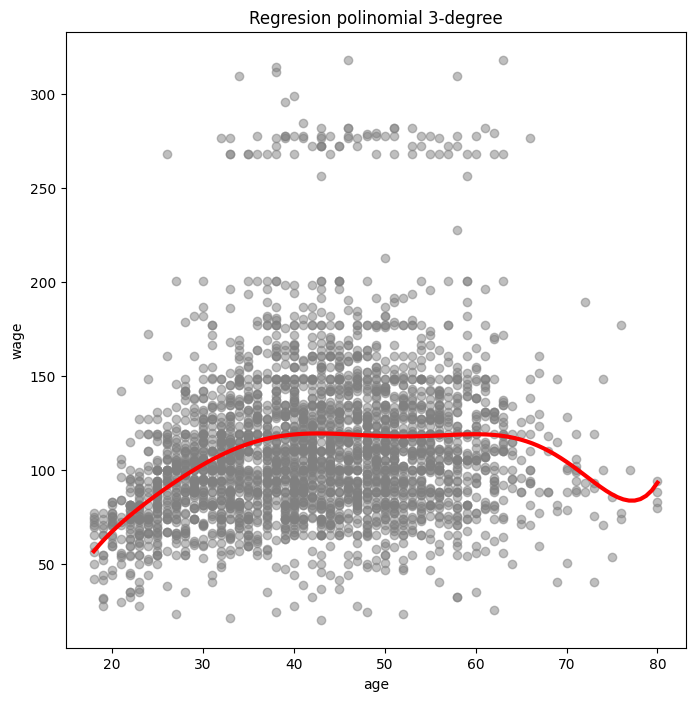

In [21]:
age_grid = np.linspace(wage["age"].min(),
                      wage["age"].max(),
                      100)
predicted = model.predict(design.transform(pd.DataFrame({"age": age_grid})))
fig, ax = plt.subplots(figsize=(8,8))
# Grafico de los puntos
ax.scatter(age, y,
           alpha=.5,
           facecolor="gray");
# Grafico de la funcion de regresion
ax.plot(age_grid, predicted,
        color="red",
        linewidth=3)
ax.set_title("Regresion polinomial 3-degree")
ax.set_xlabel("age")
ax.set_ylabel("wage")


Vamos a validar los resultados con cross validation con k = 10

In [22]:
k = 10
kfold = skm.KFold(k,
              shuffle=True,
              random_state=2)
results = skm.cross_val_score(skl.LinearRegression(),
                              X,
                              y,
                              scoring="neg_mean_squared_error",
                              cv=kfold)
print(f"Simple Polinomial regression 3-d con un score de: {np.mean(-results)}")

Simple Polinomial regression 3-d con un score de: 1592.9460359355835


#### Wise Selection of d

Ahora vamos a buscar el mejor modelo con diferentes valores para d:


In [9]:
degrees = np.arange(1, 10 + 1)
mse = np.zeros(10)
kfold = skm.KFold(10,
              shuffle=True,
              random_state=2)
for d in degrees:

  design = MS([poly("age", degree=d)])

  pipe = Pipeline([("design", design),
                  ("model", skl.LinearRegression())])

  results = skm.cross_validate(pipe,
                              wage,
                              wage["wage"],
                              scoring="neg_mean_squared_error",
                               cv=kfold)

  mse[d-1] = np.mean(-results["test_score"])

Text(0, 0.5, 'MSE')

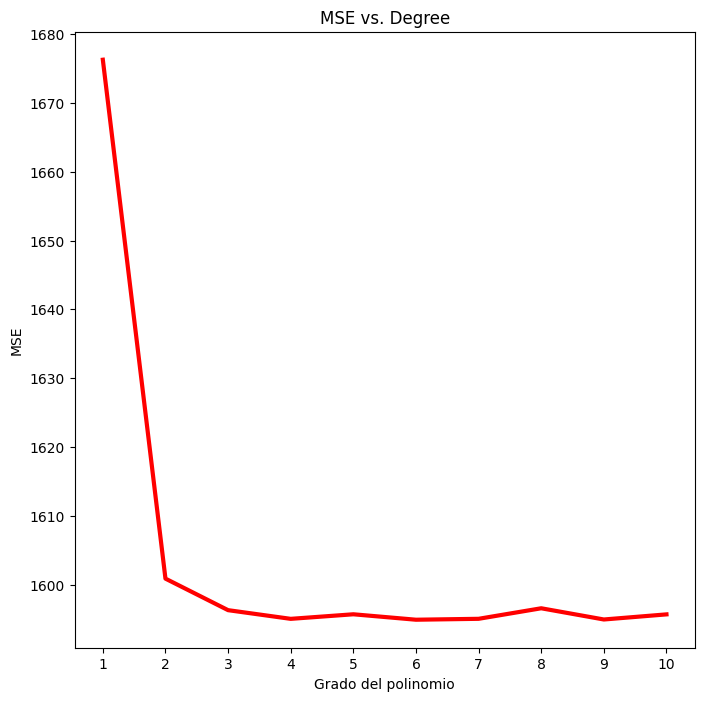

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(degrees, mse,
        linewidth=3,
        color="red")
ax.set_xticks(degrees)
ax.set_title("MSE vs. Degree")
ax.set_xlabel("Grado del polinomio")
ax.set_ylabel("MSE")

Podemos apreciar una caida mas que evidente con un modelo con 3 a 4 grados en el polinomio


In [11]:
# graficamos el modelo con 4-degree
kfold = skm.KFold(10,
              shuffle=True,
              random_state=2)
design = MS([poly("age", degree=4)])

pipe = Pipeline([("design", design),
                ("model", skl.LinearRegression())])

results = skm.cross_validate(pipe,
                             wage,
                             wage["wage"],
                             scoring="neg_mean_squared_error",
                             cv=kfold)
print(f"Simple Polinomial regression 4-d con un score de: {np.mean(-results['test_score'])}")

Simple Polinomial regression 4-d con un score de: 1595.0572027232408


Veamos el analisis ANOVA con modelos polinomiales con d tomando valores de 1 a 6

In [12]:
models = []
for d in range(1, 6 + 1):
  design = MS([poly("age", degree=d)])
  X = design.fit_transform(wage)

  model = sm.OLS(wage["wage"], X).fit()
  models.append(model)

In [13]:
print(anova_lm(*models))

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.663571  2.285169e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.893609  1.674794e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.811683  5.098933e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.805371  3.695646e-01
5    2993.0  4.766389e+06      1.0    3932.257665    2.469216  1.162015e-01


Con estos resultados, podemos decir que el valor p es significativo hasta un modelo  con d = 4 sin embargo el modelo con d=3 es mejor ya que el cambio no es tan significativo.

##### GridSearch

In [34]:
age = wage["age"]
y = wage["wage"]

k=5
kfold = skm.KFold(k,
                  shuffle=True,
                  random_state=1)
params_grid = {"poly__degree": np.arange(1, 20)}

pipe = Pipeline([("poly", PolynomialFeatures()),
                 ("model", skl.LinearRegression())])

cv_grid = skm.GridSearchCV(pipe,
                           param_grid=params_grid,
                           cv=kfold).fit(np.reshape(age, (-1,1)),
                                         y)
cv_grid


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('model', LinearRegression())]),
             param_grid={'poly__degree': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [36]:
cv_grid.best_score_


np.float64(0.08474942669380907)

Podemos apreciar que el mejhor modelo es un de 8-degree

### b

In [17]:
# ahora vamos a buscar los cortes para un step function
scores = []
cuts = np.arange(1, 20)
kfold = skm.KFold(10,
              shuffle=True,
              random_state=2)
for c in cuts:
  wage["cut"] = pd.cut(wage["age"], c)
  design = MS(["cut"])
  X = design.fit_transform(wage)

  results = skm.cross_validate(skl.LinearRegression(),
                               X,
                               wage["wage"],
                               scoring="neg_mean_squared_error",
                               cv=kfold)

  scores.append(np.mean(-results["test_score"]))

Text(0, 0.5, 'MSE')

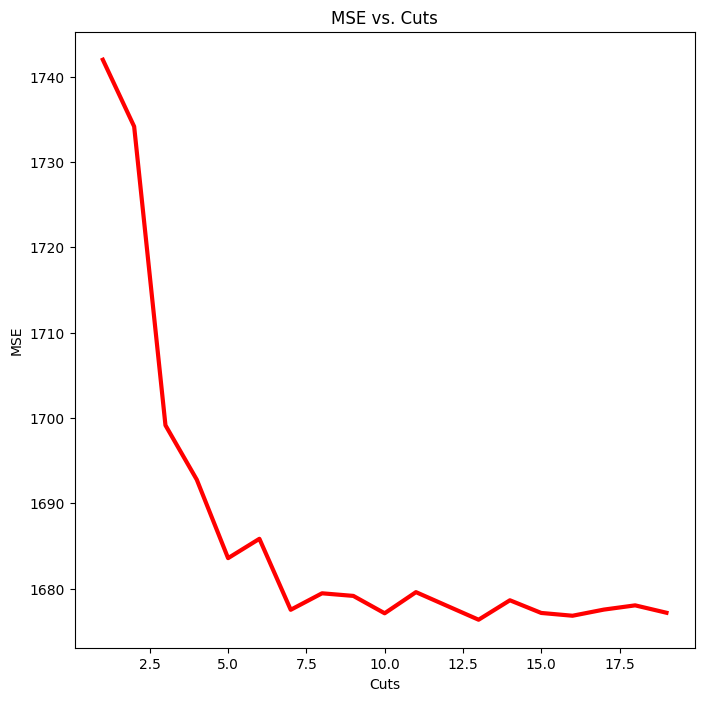

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(cuts, scores,
        linewidth=3,
        color="red")
ax.set_title("MSE vs. Cuts")
ax.set_xlabel("Cuts")
ax.set_ylabel("MSE")


El número óptimo de cortes es: 13
MSE mínimo: 1676.3553


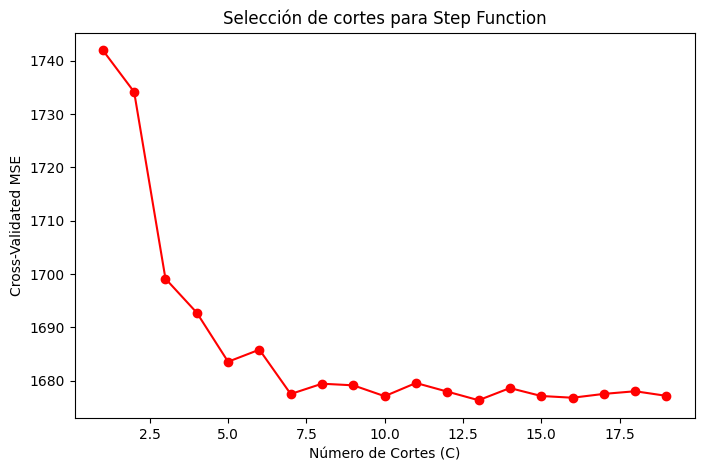

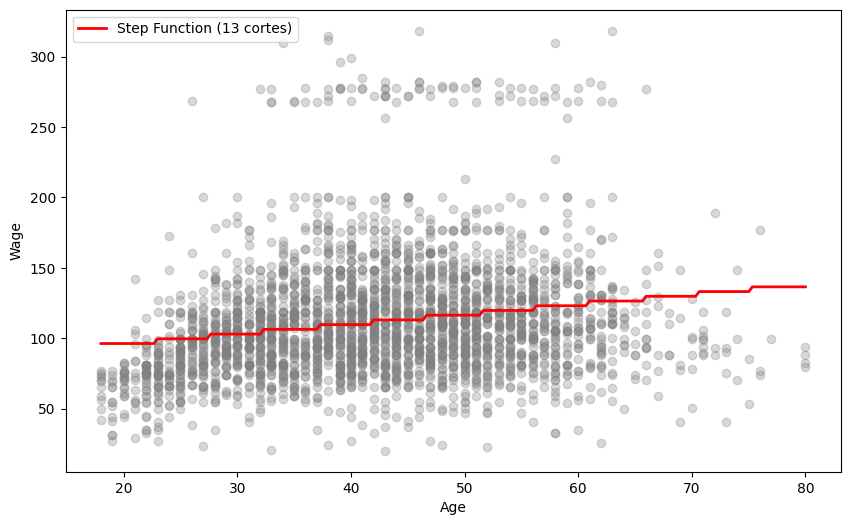

In [19]:
import matplotlib.pyplot as plt

# 1. Encontrar el mejor 'C' (número de cortes)
best_c_idx = np.argmin(scores)
best_c = cuts[best_c_idx]
print(f"El número óptimo de cortes es: {best_c}")
print(f"MSE mínimo: {scores[best_c_idx]:.4f}")

# Graficar el error para ver el "codo"
plt.figure(figsize=(8, 5))
plt.plot(cuts, scores, marker='o', color='red')
plt.xlabel("Número de Cortes (C)")
plt.ylabel("Cross-Validated MSE")
plt.title("Selección de cortes para Step Function")
plt.show()

# ---------------------------------------------------------
# 2. Graficar el ajuste final (Fit) con el 'best_c'
# ---------------------------------------------------------

# A. Re-entrenar el modelo con TODOS los datos y el mejor corte
wage["cut"] = pd.cut(wage["age"], best_c)
design = MS(["cut"])
X_full = design.fit_transform(wage)
final_model = skl.LinearRegression().fit(X_full, wage["wage"])

# B. Crear datos ficticios para dibujar la línea escalonada
# Usamos linspace para tener muchos puntos y que se vean los escalones
age_grid = np.linspace(wage["age"].min(), wage["age"].max(), 200)
df_grid = pd.DataFrame({"age": age_grid})

# IMPORTANTE: Usar los mismos cortes (bins) que los datos originales
# Para que coincida exacto, le pasamos los mismos bordes o dejamos que pandas lo infiera igual
# Lo más seguro es usar 'retbins=True' en el original, pero aquí pd.cut suele ser consistente
df_grid["cut"] = pd.cut(df_grid["age"], bins=best_c)

# Transformar y Predecir
# Nota: Puede que necesites manejar bordes si linspace se sale por decimales,
# pero pd.cut suele aguantarlo bien.
X_grid = design.transform(df_grid)
preds = final_model.predict(X_grid)

# C. Plot Final
fig, ax = plt.subplots(figsize=(10, 6))
# Puntos reales (gris)
ax.scatter(wage["age"], wage["wage"], facecolor="gray", alpha=0.3)
# Línea de predicción (roja)
ax.plot(age_grid, preds, color="red", linewidth=2, label=f"Step Function ({best_c} cortes)")

ax.set_xlabel("Age")
ax.set_ylabel("Wage")
ax.legend()
plt.show()